#   Q18 Machine Learning Rolling Basis

In this example we predict whether the price will rise or fall by using supervised learning (Bayesian Ridge Regression). This template represents a starting point for developing a system which can take part to the **Q18 NASDAQ-100 Stock Long-Short contest**.

It consists of two parts.

* In the **first part** we just perform a global training of the time series using all time series data. We disregard the sequential aspect of the data and use also future data to train past data.

* In the **second part** we use the built-in backtester and perform training and prediction on a rolling basis in order to avoid forward looking. Please note that we are using a **specialized** version of the Quantiacs backtester which dramatically speeds up the the backtesting process by retraining your model on a regular basis.

**Features for learning**: we will use several technical indicators trying to capture different features. You can have a look at [**Technical Indicators**](https://quantiacs.com/documentation/en/user_guide/technical_indicators.html).

Please note that:

* Your trading algorithm can open short and long positions.

* At each point in time your algorithm can trade all or a subset of the stocks which at that point of time are or were part of the NASDAQ-100 stock index. Note that the composition of this set changes in time, and Quantiacs provides you with an appropriate filter function for selecting them.

* The Sharpe ratio of your system since January 1st, 2006, has to be larger than 1.

* Your system cannot be a copy of the current examples. We run a correlation filter on the submissions and detect duplicates.

* For simplicity we will use a single asset. It pays off to use more assets, ideally uncorrelated, and diversify your positions for a more solid Sharpe ratio.

More details on the rules can be found [here](https://quantiacs.com/contest).

**Need help?** Check the [**Documentation**](https://quantiacs.com/documentation/en/) and find solutions/report problems in the [**Forum**](https://quantiacs.com/community/categories) section.

**More help with Jupyter?** Check the official [**Jupyter**](https://jupyter.org/) page.

Once you are done, click on **Submit to the contest** and take part to our competitions.

API reference:

* **data**: check how to work with [data](https://quantiacs.com/documentation/en/reference/data_load_functions.html);

* **backtesting**: read how to run the [simulation](https://quantiacs.com/documentation/en/reference/evaluation.html) and check the results.

Need to use the optimizer function to automate tedious tasks?

* **optimization**: read more on our [article](https://quantiacs.com/community/topic/29/optimizing-and-monitoring-a-trading-system-with-quantiacs).

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }
// disable widget scrolling

<IPython.core.display.Javascript object>

In [ ]:
! pip install git+https://github.com/quantiacs/toolbox.git 2>/dev/null


  Cloning https://github.com/quantiacs/toolbox.git to /tmp/pip-req-build-7k4e1ba6
  Resolved https://github.com/quantiacs/toolbox.git to commit 272e66e017d3eb6d40517ffa39cd6a92dc5072d8
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 MB 16.1 MB/s eta 0:00:00
  Created wheel for qnt: filename=qnt-0.0.407-py3-none-any.whl size=115361 sha256=62a724e3aa7b4175c9934b1bbdc6af6efba6a8b37d0330eb37dc04aad658f739
  Stored in directory: /tmp/pip-ephem-wheel-cache-qnyqpaxb/wheels/ca/03/48/1dbd01eee19642348a025488a55e2290c63d6b83473b2b8b9a
Successfully built qnt
  Attempt

In [ ]:
!pip install ta-lib

  Using cached ta_lib-0.6.1.tar.gz (372 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for ta-lib (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for ta-lib
Failed to build ta-lib
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (ta-lib)


In [ ]:
import os

os.environ['API_KEY'] = 'XXXX'
os.environ['DATA_BASE_URL'] = 'https://data-api.quantiacs.io/'
os.environ['CACHE_RETENTION'] = '6'
os.environ['CACHE_DIR'] = 'data-cache'

In [ ]:
import logging

import xarray as xr  # xarray for data manipulation

import qnt.data as qndata     # functions for loading data
import qnt.backtester as qnbt # built-in backtester
import qnt.ta as qnta         # technical analysis library
import qnt.stats as qnstats   # statistical functions

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

np.seterr(divide = "ignore")

from qnt.ta.macd import macd
from qnt.ta.rsi  import rsi
from qnt.ta.stochastic import stochastic_k, stochastic, slow_stochastic

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor  # Importing Random Forest Regressor
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error

In [ ]:
# Loading S&P 500 stock data for 20 assets
assets = [
    "NAS:SPY", "NAS:AAPL", "NAS:MSFT", "NAS:GOOG", "NAS:AMZN", "NAS:TSLA", "NAS:META",
    "NAS:NVDA", "NAS:BRK.B", "NAS:JNJ", "NAS:V", "NAS:UNH", "NAS:HD", "NAS:PYPL", "NAS:DIS",
    "NAS:XOM", "NAS:PFE", "NAS:CVX", "NAS:CSCO", "NAS:BA"
]

stock_data = qndata.stocks.load_ndx_data(tail=365 * 5, assets=assets)

# Checking the data
print(stock_data)
print(stock_data.shape)

| |       #                                      | 224160 Elapsed Time: 0:00:00


fetched chunk 1/1 2s
Data loaded 2s
<xarray.DataArray 'stocks_nasdaq100' (field: 8, time: 1255, asset: 20)> Size: 2MB
array([[[7.92975e+01, 9.32500e+01,         nan, ...,         nan,
                 nan,         nan],
        [7.96450e+01, 9.48045e+01,         nan, ...,         nan,
                 nan,         nan],
        [7.94800e+01, 9.42555e+01,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [2.33530e+02, 2.18060e+02,         nan, ...,         nan,
                 nan,         nan],
        [2.34750e+02, 2.20440e+02,         nan, ...,         nan,
                 nan,         nan],
        [2.34635e+02, 2.22830e+02,         nan, ...,         nan,
                 nan,         nan]],

       [[7.90000e+01, 9.30000e+01,         nan, ...,         nan,
                 nan,         nan],
        [7.93275e+01, 9.41670e+01,         nan, ...,         nan,
                 nan,         nan],
        [7.89125e+01, 9.36380e+01,         nan, ...

In [ ]:
def get_features(data):
    """Builds the features used for learning:
       * a trend indicator;
       * the moving average convergence divergence;
       * a volatility measure;
       * the stochastic oscillator;
       * the relative strength index;
       * the logarithm of the closing price;
       * a simple moving average (SMA);
       * Bollinger Bands (calculated manually).
       These features can be modified and new ones can be added easily.
    """

    # trend:
    trend = qnta.roc(qnta.lwma(data.sel(field="close"), 60), 1)

    # moving average convergence divergence (MACD):
    macd = qnta.macd(data.sel(field="close"))
    macd2_line, macd2_signal, macd2_hist = qnta.macd(data, 12, 26, 9)

    # volatility:
    volatility = qnta.tr(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"))
    volatility = volatility / data.sel(field="close")
    volatility = qnta.lwma(volatility, 14)

    # the stochastic oscillator:
    k, d = qnta.stochastic(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"), 14)

    # the relative strength index:
    rsi = qnta.rsi(data.sel(field="close"))

    # the logarithm of the closing price:
    price = data.sel(field="close").ffill("time").bfill("time").fillna(0)  # fill NaN
    price = np.log(price)

    # new features: Simple Moving Average (SMA)
    sma = qnta.sma(data.sel(field="close"), 20)  # 20-period SMA

    # Bollinger Bands (manual calculation)
    window = 20  # 20-period window
    moving_avg = sma  # Use the 20-period SMA for middle band
    rolling_std = data.sel(field="close").rolling(time=window).std()
    bollinger_upper = moving_avg + (rolling_std * 2)  # Upper band: SMA + 2 * standard deviation
    bollinger_lower = moving_avg - (rolling_std * 2)  # Lower band: SMA - 2 * standard deviation

    # combine the features:
    result = xr.concat(
        [trend, macd2_signal.sel(field="close"), volatility, d, rsi, price, sma, bollinger_upper, bollinger_lower],
        pd.Index(
            ["trend", "macd", "volatility", "stochastic_d", "rsi", "price", "sma", "bollinger_upper", "bollinger_lower"],
            name="field"
        )
    )

    return result.transpose("time", "field", "asset")


In [ ]:
# Displaying the new features
my_features = get_features(stock_data)

display(my_features.sel(field="bollinger_upper").to_pandas())
display(my_features.sel(field="bollinger_lower").to_pandas())
display(my_features.sel(field="sma").to_pandas())

asset,NAS:AAPL,NAS:AMZN,NAS:BA,NAS:BRK.B,NAS:CSCO,NAS:CVX,NAS:DIS,NAS:GOOG,NAS:HD,NAS:JNJ,NAS:META,NAS:MSFT,NAS:NVDA,NAS:PFE,NAS:PYPL,NAS:SPY,NAS:TSLA,NAS:UNH,NAS:V,NAS:XOM
time,,,,,,,,,,,,,,,,,,,,
2020-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-08,259.695186,232.874877,NaN,NaN,60.045274,NaN,NaN,200.367209,NaN,NaN,637.766280,457.281774,146.784332,NaN,91.793403,NaN,475.970004,NaN,NaN,NaN
2025-01-10,260.615375,233.066662,NaN,NaN,60.045871,NaN,NaN,199.766379,NaN,NaN,637.379625,456.918181,146.796232,NaN,92.036223,NaN,476.334150,NaN,NaN,NaN
2025-01-13,261.680956,232.581498,NaN,NaN,60.049231,NaN,NaN,199.484513,NaN,NaN,633.958157,455.474605,146.594122,NaN,91.784046,NaN,476.145551,NaN,NaN,NaN


asset,NAS:AAPL,NAS:AMZN,NAS:BA,NAS:BRK.B,NAS:CSCO,NAS:CVX,NAS:DIS,NAS:GOOG,NAS:HD,NAS:JNJ,NAS:META,NAS:MSFT,NAS:NVDA,NAS:PFE,NAS:PYPL,NAS:SPY,NAS:TSLA,NAS:UNH,NAS:V,NAS:XOM
time,,,,,,,,,,,,,,,,,,,,
2020-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-08,239.806814,217.765123,NaN,NaN,57.654726,NaN,NaN,187.431791,NaN,NaN,579.735720,413.966226,127.587668,NaN,84.366597,NaN,375.061996,NaN,NaN,NaN
2025-01-10,237.794625,216.963338,NaN,NaN,57.656129,NaN,NaN,188.696621,NaN,NaN,579.776375,411.891819,127.659768,NaN,83.583777,NaN,374.072850,NaN,NaN,NaN
2025-01-13,235.520044,216.268502,NaN,NaN,57.669769,NaN,NaN,188.536487,NaN,NaN,580.762843,410.155395,127.253878,NaN,83.159954,NaN,372.115449,NaN,NaN,NaN


asset,NAS:AAPL,NAS:AMZN,NAS:BA,NAS:BRK.B,NAS:CSCO,NAS:CVX,NAS:DIS,NAS:GOOG,NAS:HD,NAS:JNJ,NAS:META,NAS:MSFT,NAS:NVDA,NAS:PFE,NAS:PYPL,NAS:SPY,NAS:TSLA,NAS:UNH,NAS:V,NAS:XOM
time,,,,,,,,,,,,,,,,,,,,
2020-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-08,249.7510,225.3200,NaN,NaN,58.8500,NaN,NaN,193.8995,NaN,NaN,608.7510,435.6240,137.1860,NaN,88.080,NaN,425.5160,NaN,NaN,NaN
2025-01-10,249.2050,225.0150,NaN,NaN,58.8510,NaN,NaN,194.2315,NaN,NaN,608.5780,434.4050,137.2280,NaN,87.810,NaN,425.2035,NaN,NaN,NaN
2025-01-13,248.6005,224.4250,NaN,NaN,58.8595,NaN,NaN,194.0105,NaN,NaN,607.3605,432.8150,136.9240,NaN,87.472,NaN,424.1305,NaN,NaN,NaN


In [ ]:
def get_target_classes(data):
    """ Target classes for predicting if price goes up or down."""

    price_current = data.sel(field="close")
    price_future  = qnta.shift(price_current, -1)

    class_positive = 1 # prices goes up
    class_negative = 0 # price goes down

    target_price_up = xr.where(price_future > price_current, class_positive, class_negative)

    return target_price_up

In [ ]:
# displaying the target classes:
my_targetclass = get_target_classes(stock_data)
display(my_targetclass.to_pandas())

asset,NAS:AAPL,NAS:AMZN,NAS:BA,NAS:BRK.B,NAS:CSCO,NAS:CVX,NAS:DIS,NAS:GOOG,NAS:HD,NAS:JNJ,NAS:META,NAS:MSFT,NAS:NVDA,NAS:PFE,NAS:PYPL,NAS:SPY,NAS:TSLA,NAS:UNH,NAS:V,NAS:XOM
time,,,,,,,,,,,,,,,,,,,,
2020-01-21,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0
2020-01-22,1,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,1,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-27,1,1,0,0,1,0,0,1,0,0,1,1,1,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-08,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2025-01-10,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
2025-01-13,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
def get_model():
    """This is a constructor for the ML model (Random Forest) which can be easily
       modified for using different models.
    """

    model = RandomForestRegressor(n_estimators=100, random_state=42)  # 100 trees and random seed for reproducibility
    return model

In [ ]:
# Create and train the models working on an asset-by-asset basis.

asset_name_all = stock_data.coords["asset"].values

models = dict()

for asset_name in asset_name_all:

        # drop missing values:
        target_cur   = my_targetclass.sel(asset=asset_name).dropna("time", "any")
        features_cur = my_features.sel(asset=asset_name).dropna("time", "any")

        # align features and targets:
        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
            # not enough points for training
                continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except:
            logging.exception("model training failed")

print(models)

<ipython-input-30-383029879c06>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-30-383029879c06>:11: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-30-383029879c06>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-30-383029879c06>:11: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-30-383029879c06>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was de

{'NAS:AAPL': RandomForestRegressor(random_state=42), 'NAS:AMZN': RandomForestRegressor(random_state=42), 'NAS:CSCO': RandomForestRegressor(random_state=42), 'NAS:GOOG': RandomForestRegressor(random_state=42), 'NAS:META': RandomForestRegressor(random_state=42), 'NAS:MSFT': RandomForestRegressor(random_state=42), 'NAS:NVDA': RandomForestRegressor(random_state=42), 'NAS:PYPL': RandomForestRegressor(random_state=42), 'NAS:TSLA': RandomForestRegressor(random_state=42)}


<ipython-input-30-383029879c06>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-30-383029879c06>:11: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-30-383029879c06>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-30-383029879c06>:11: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-30-383029879c06>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was de

Feature: 0, Score: 0.11821
Feature: 1, Score: 0.11463
Feature: 2, Score: 0.14128
Feature: 3, Score: 0.13496
Feature: 4, Score: 0.14797
Feature: 5, Score: 0.09882
Feature: 6, Score: 0.06602
Feature: 7, Score: 0.08899
Feature: 8, Score: 0.08911


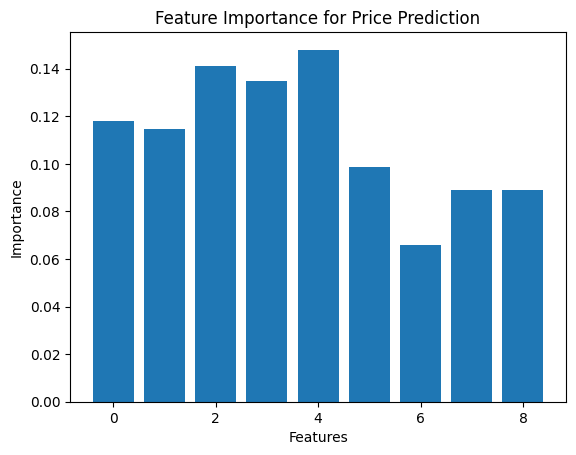

In [ ]:
# Assuming you've already trained the Random Forest model and it's stored in `models["NAS:AAPL"]`

# Get the feature importances for the Random Forest model
importance = models["NAS:AAPL"].feature_importances_

# Print the feature importances
for i, v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i, v))

# Plot the feature importances
plt.bar([x for x in range(len(importance))], importance)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance for Price Prediction')
plt.show()

In [ ]:
# Performs prediction and generates output weights:

asset_name_all = stock_data.coords["asset"].values
weights = xr.zeros_like(stock_data.sel(field="close"))

for asset_name in asset_name_all:
    if asset_name in models:
        model = models[asset_name]
        features_all = my_features
        features_cur = features_all.sel(asset=asset_name).dropna("time", "any")
        if len(features_cur.time) < 1:
            continue
        try:
            weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)
        except KeyboardInterrupt as e:
            raise e
        except:
            logging.exception("model prediction failed")

print(weights)

<ipython-input-32-d5c983142616>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-32-d5c983142616>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-32-d5c983142616>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-32-d5c983142616>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-32-d5c983142616>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was de

<xarray.DataArray 'stocks_nasdaq100' (time: 1255, asset: 20)> Size: 201kB
array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.12, 0.17, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.72, 0.81, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.08, 0.12, 0.  , ..., 0.  , 0.  , 0.  ]])
Coordinates:
  * asset    (asset) <U9 720B 'NAS:AAPL' 'NAS:AMZN' ... 'NAS:V' 'NAS:XOM'
  * time     (time) datetime64[ns] 10kB 2020-01-21 2020-01-22 ... 2025-01-15
    field    <U5 20B 'close'


<ipython-input-32-d5c983142616>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.



In [ ]:
def get_sharpe(stock_data, weights):
    """Calculates the Sharpe ratio"""
    rr = qnstats.calc_relative_return(stock_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(stock_data, weights)
sharpe

5.751129046033582

The sharpe ratio using the method above follows from **forward looking**. Predictions for (let us say) 2017 know about the relation between features and targets in 2020. Let us visualize the results:

In [ ]:
import qnt.graph as qngraph

statistics = qnstats.calc_stat(stock_data, weights)

display(statistics.to_pandas().tail())

performance = statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())

# check for correlations with existing strategies:
qnstats.print_correlation(weights,stock_data)

field,equity,relative_return,volatility,underwater,max_drawdown,sharpe_ratio,mean_return,bias,instruments,avg_turnover,avg_holding_time
time,,,,,,,,,,,
2025-01-08,107.636671,0.000067,0.274429,-0.010588,-0.277913,5.707670,1.566349,1.0,9.0,0.518233,3.682577
2025-01-10,106.662880,-0.009047,0.274381,-0.019539,-0.277913,5.684553,1.559731,1.0,9.0,0.518396,3.682145
2025-01-13,107.050749,0.003636,0.274271,-0.015974,-0.277913,5.686635,1.559680,1.0,9.0,0.518692,3.680548
2025-01-14,108.554904,0.014051,0.274200,-0.002147,-0.277913,5.707317,1.564944,1.0,9.0,0.518607,3.680672
2025-01-15,111.670469,0.028700,0.274315,0.000000,-0.277913,5.751129,1.577624,1.0,9.0,0.518838,3.680285


time,2025-01-15
field,
sharpe_ratio,5.751129


NOTICE: The environment variable ENGINE_CORRELATION_URL was not specified. The default value is 'https://quantiacs.io/referee/submission/forCorrelation'
NOTICE: The environment variable STATAN_CORRELATION_URL was not specified. The default value is 'https://quantiacs.io/statan/correlation'
NOTICE: The environment variable PARTICIPANT_ID was not specified. The default value is '0'



Ok. This strategy does not correlate with other strategies.


In [ ]:
"""R2 (coefficient of determination) regression score function."""
r2_score(my_targetclass, weights, multioutput="variance_weighted")

0.7592594393608894

In [ ]:
"""The explained variance score explains the dispersion of errors of a given dataset"""
explained_variance_score(my_targetclass, weights, multioutput="uniform_average")

0.8927872233347915

In [ ]:
"""The explained variance score explains the dispersion of errors of a given dataset"""
mean_absolute_error(my_targetclass, weights)

0.08731354581673302

Let us now use the Quantiacs **backtester** for avoiding **forward looking**.

The backtester performs some transformations: it trains the model on one slice of data (using only data from the past) and predicts the weights for the following slice on a rolling basis:

In [ ]:
def train_model(data):
    """Create and train the model working on an asset-by-asset basis."""

    asset_name_all = data.coords["asset"].values
    features_all   = get_features(data)
    target_all     = get_target_classes(data)

    models = dict()

    for asset_name in asset_name_all:

        # drop missing values:
        target_cur   = target_all.sel(asset=asset_name).dropna("time", "any")
        features_cur = features_all.sel(asset=asset_name).dropna("time", "any")

        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
                continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except:
            logging.exception("model training failed")

    return models

In [ ]:
def predict_weights(models, data):
    """The model predicts if the price is going up or down.
       The prediction is performed for several days in order to speed up the evaluation."""

    asset_name_all = data.coords["asset"].values
    weights = xr.zeros_like(data.sel(field="close"))

    for asset_name in asset_name_all:
        if asset_name in models:
            model = models[asset_name]
            features_all = get_features(data)
            features_cur = features_all.sel(asset=asset_name).dropna("time", "any")

            if len(features_cur.time) < 1:
                continue

            try:
                weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)

            except KeyboardInterrupt as e:
                raise e

            except:
                logging.exception("model prediction failed")

    return weights

In [ ]:
# Calculate weights using the backtester:
weights = qnbt.backtest_ml(
    train                         = train_model,
    predict                       = predict_weights,
    train_period                  =  2 *365,  # the data length for training in calendar days
    retrain_interval              = 10 *365,  # how often we have to retrain models (calendar days)
    retrain_interval_after_submit = 1,        # how often retrain models after submission during evaluation (calendar days)
    predict_each_day              = False,    # Is it necessary to call prediction for every day during backtesting?
                                              # Set it to True if you suspect that get_features is looking forward.
    competition_type              = "stocks_nasdaq100",  # competition type
    lookback_period               = 365,                 # how many calendar days are needed by the predict function to generate the output
    start_date                    = "2023-01-01",        # backtest start date
    analyze                       = True,
    build_plots                   = True  # do you need the chart?
)

Run the last iteration...


| | #                                              | 9060 Elapsed Time: 0:00:00
| |            #                                | 2302584 Elapsed Time: 0:00:01


fetched chunk 1/1 22s
Data loaded 23s


<ipython-input-38-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-38-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-38-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-38-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-38-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was de

fetched chunk 1/1 4s
Data loaded 4s
Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
WARNING! Strategy trades non-liquid assets.
Fix liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.


NOTICE: The environment variable OUTPUT_PATH was not specified. The default value is 'fractions.nc.gz'


Write output: fractions.nc.gz


NOTICE: The environment variable OUT_STATE_PATH was not specified. The default value is 'state.out.pickle.gz'


State saved.
---
Run First Iteration...


| | #                                              | 9060 Elapsed Time: 0:00:00
| |            #                                | 2398037 Elapsed Time: 0:00:01


fetched chunk 1/1 5s
Data loaded 6s


<ipython-input-38-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-38-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-38-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-38-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-38-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was de

---
Run all iterations...
Load data...


<ipython-input-39-df9da7badac1>:12: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-39-df9da7badac1>:12: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

| | #                                              | 9060 Elapsed Time: 0:00:00
| |             #                               | 3463931 Elapsed Time: 0:00:01


fetched chunk 1/2 4s


| |             #                               | 2398244 Elapsed Time: 0:00:01


fetched chunk 2/2 8s
Data loaded 9s


| | #                                              | 9060 Elapsed Time: 0:00:00
| |            #                                | 2354742 Elapsed Time: 0:00:01


fetched chunk 1/1 6s
Data loaded 6s
Backtest...


<ipython-input-38-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-38-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-38-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-38-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-38-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was de

fetched chunk 1/1 6s
Data loaded 6s
Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
WARNING! Strategy trades non-liquid assets.
Fix liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.


NOTICE: The environment variable OUTPUT_PATH was not specified. The default value is 'fractions.nc.gz'


Write output: fractions.nc.gz


NOTICE: The environment variable OUT_STATE_PATH was not specified. The default value is 'state.out.pickle.gz'


State saved.
---
Analyze results...
Check...
Check liquidity...
Ok.
Check missed dates...
Ok.
Check the sharpe ratio...


WARNING! There are not enough points in the data
The first point(2022-11-04) should be earlier than 2006-01-01
Load data more historical data.
WARNING! There are not enough points in the output.
The output series should start from 2006-01-01 or earlier instead of 2023-01-03


Period: 2022-11-04 - 2025-01-15
Sharpe Ratio = 0.9058487026551051
Ok.
---
Align...
Calc global stats...
---
Calc stats per asset...
Build plots...
---
Select the asset (or leave blank to display the overall stats):


interactive(children=(Combobox(value='', description='asset', options=('', 'NAS:AAL', 'NAS:AAPL', 'NAS:ABNB', …

100% (511 of 511) |######################| Elapsed Time: 0:02:22 Time:  0:02:22


In [ ]:
print(weights.keys())  # This will show the keys in the result dictionary


AttributeError: 'DataArray' object has no attribute 'keys'

[[0.         0.01539897 0.00933271 ... 0.         0.         0.        ]
 [0.         0.01193521 0.00852515 ... 0.         0.         0.        ]
 [0.         0.01489362 0.00614657 ... 0.         0.         0.        ]
 ...
 [0.         0.00740096 0.01806704 ... 0.         0.         0.        ]
 [0.         0.00612826 0.01794703 ... 0.         0.         0.        ]
 [0.         0.00649351 0.01925661 ... 0.         0.         0.        ]]


<ipython-input-48-afed78c2b53e>:10: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



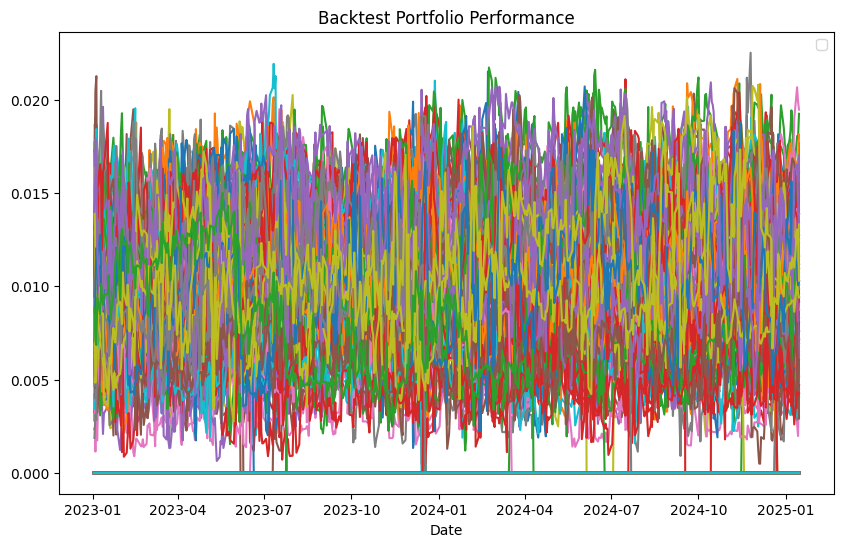

In [ ]:
# Access the values (assuming 'backtest_results' is a DataArray)
values = weights.values
print(values)  # This will print the raw data for inspection

# If the values represent portfolio performance, you can plot them
plt.figure(figsize=(10, 6))
plt.plot(weights.time, values)  # Assuming time is the correct dimension
plt.xlabel("Date")
plt.title("Backtest Portfolio Performance")
plt.legend()
plt.show()

# Calculate weights using the backtester:
weights = qnbt.backtest_ml(
    train                         = train_model,
    predict                       = predict_weights,
    train_period                  =  2 *365,  # the data length for training in calendar days
    retrain_interval              = 10 *365,  # how often we have to retrain models (calendar days)
    retrain_interval_after_submit = 1,        # how often retrain models after submission during evaluation (calendar days)
    predict_each_day              = False,    # Is it necessary to call prediction for every day during backtesting?
                                              # Set it to True if you suspect that get_features is looking forward.
    competition_type              = "stocks_nasdaq100",  # competition type
    lookback_period               = 365,                 # how many calendar days are needed by the predict function to generate the output
    start_date                    = "2005-01-01",        # backtest start date
    analyze                       = True,
    build_plots                   = True  # do you need the chart?
)

The Sharpe ratio is obviously smaller as the training process is not looking forward (as it happens by processing data on a global basis), but performed on a rolling basis.

# May I import libraries?

Yes, please refer to the file **init.ipynb** in your home directory. You can for example use:

! conda install -y scikit-learn

# How to load data?

Daily stock data for the **Q18 Nasdaq-100** contest can be loaded using:
```python
data = qndata.stocks.load_ndx_data(tail = 17*365, dims = ("time", "field", "asset"))
```

Cryptocurrency daily data used for the Q16/Q17 contests can be loaded using:
```python
data = qndata.cryptodaily.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

Futures data for the Q15 contest can be loaded using:
```python
data= qndata.futures.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

BTC Futures data for the Q15 contest can be loaded using:
```python
data= qndata.cryptofutures.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

# How to view a list of all tickers?

```python
data.asset.to_pandas().to_list()
```

# How to see which fields are available?

```python
data.field.to_pandas().to_list()
```

# How to load specific tickers?

```python
data = qndata.stocks.load_ndx_data(tail=17 * 365, assets=["NAS:AAPL", "NAS:AMZN"])
```

# How to select specific tickers after loading all data?

```python
def get_data_filter(data, assets):
    filler= data.sel(asset=assets)
    return filler

get_data_filter(data, ["NAS:AAPL", "NAS:AMZN"])
```

# How to get the prices for the previous day?

```python
qnta.shift(data.sel(field="open"), periods=1)
```

or:

```python
data.sel(field="open").shift(time=1)
```

# How to get the Sharpe ratio?

```python
import qnt.stats as qnstats

def get_sharpe(market_data, weights):
    rr = qnstats.calc_relative_return(market_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(data, weights) # weights.sel(time=slice("2006-01-01",None))
```

# How do I get a list of the top 3 assets ranked by Sharpe ratio?

```python
import qnt.stats as qnstats

data = qndata.stocks.load_ndx_data(tail = 17*365, dims = ("time", "field", "asset"))

def get_best_instruments(data, weights, top_size):
    # compute statistics:
    stats_per_asset = qnstats.calc_stat(data, weights, per_asset=True)
    # calculate ranks of assets by "sharpe_ratio":
    ranks = (-stats_per_asset.sel(field="sharpe_ratio")).rank("asset")
    # select top assets by rank "top_period" days ago:
    top_period = 1
    rank = ranks.isel(time=-top_period)
    top = rank.where(rank <= top_size).dropna("asset").asset

    # select top stats:
    top_stats = stats_per_asset.sel(asset=top.values)

    # print results:
    print("SR tail of the top assets:")
    display(top_stats.sel(field="sharpe_ratio").to_pandas().tail())

    print("avg SR = ", top_stats[-top_period:].sel(field="sharpe_ratio").mean("asset")[-1].item())
    display(top_stats)
    return top_stats.coords["asset"].values

get_best_instruments(data, weights, 3)
```

# How can I check the results for only the top 3 assets ranked by Sharpe ratio?

Select the top assets and then load their data:

```python
best_assets= get_best_instruments(data, weights, 3)

data= qndata.stocks.load_ndx_data(tail = 17*365, assets=best_assets)
```

# How can prices be processed?

Simply import standard libraries, for example **numpy**:

```python
import numpy as np

high= np.log(data.sel(field="high"))
```

# How can you reduce slippage impace when trading?

Just apply some technique to reduce turnover:

```python
def get_lower_slippage(weights, rolling_time=6):
    return weights.rolling({"time": rolling_time}).max()

improved_weights = get_lower_slippage(weights, rolling_time=6)
```

# How to use technical analysis indicators?

For available indicators see the source code of the library: /qnt/ta

## ATR

```python
def get_atr(data, days=14):
    high = data.sel(field="high") * 1.0
    low  = data.sel(field="low") * 1.0
    close= data.sel(field="close") * 1.0

    return qnta.atr(high, low, close, days)

atr= get_atr(data, days=14)
```

## EMA

```python
prices= data.sel(field="high")
prices_ema= qnta.ema(prices, 15)
```

## TRIX

```python
prices= data.sel(field="high")
prices_trix= qnta.trix(prices, 15)
```

## ADL and EMA

```python
adl= qnta.ad_line(data.sel(field="close")) * 1.0
adl_ema= qnta.ema(adl, 18)
```

# How can you check the quality of your strategy?

```python
import qnt.output as qnout
qnout.check(weights, data, "stocks_nasdaq100")
```

or

```python
stat= qnstats.calc_stat(data, weights)
display(stat.to_pandas().tail())
```

or

```python
import qnt.graph   as qngraph
statistics= qnstats.calc_stat(data, weights)
display(statistics.to_pandas().tail())

performance= statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())
qnstats.print_correlation(weights, data)

```

# An example using pandas

One can work with pandas DataFrames at intermediate steps and at the end convert them to xarray data structures:

```python
def get_price_pct_change(prices):
    prices_pandas = prices.to_pandas()
    assets = data.coords["asset"].values
    for asset in assets:
        prices_pandas[asset] = prices_pandas[asset].pct_change()
    return prices_pandas

prices = data.sel(field="close") * 1.0
prices_pct_change = get_price_pct_change(prices).unstack().to_xarray()
```

# How to submit a strategy to the competition?

Check that weights are fine:

```python
import qnt.output as qnout
qnout.check(weights, data, "stocks_nasdaq100")
```

If everything is ok, write the weights to file:

```python
qnout.write(weights)
```

In your **personal account**:

* **choose** a strategy;
* click on the **Submit** button;
* select the type of competition.

At the beginning you will find the strategy under the **Checking** area:

* **Sent strategies** > **Checking**.

If technical checks are successful, the strategy will go under the **Candidates** area:

* **Sent strategies** > **Candidates**.

Otherwise it will be **Filtered**:

* **Sent strategies** > **Filtered**

and you should inspect error and warning messages.

Note that a strategy under the **Candidates** area should have a Sharpe ratio larger than 1 for being eligible for a prize. Please check warning messages in your **Candidates** area!